# MODELO SVM

In [43]:
# Importando las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import SVM as svmf
import numpy as np
from sklearn.preprocessing import StandardScaler

## Creacion de clase SVM

In [26]:
# Clase SVM (Support Vector Machine) para clasificación multiclase

class SVM:
    def __init__(self, C, epochs, alpha):
        # Inicializa los hiperparámetros del modelo SVM
        self.C = C            # Parámetro de regularización
        self.epochs = epochs  # Número de épocas de entrenamiento
        self.alpha = alpha    # Tasa de aprendizaje

    def fit(self, x, y):
        # Ajusta el modelo SVM a los datos de entrenamiento
        self.classes = np.unique(y)  # Encuentra las clases únicas en las etiquetas
        self.classifiers = {}        # Almacena los clasificadores para cada clase

        for class_label in self.classes:
            # Convierte las etiquetas en un problema binario (+1 para la clase actual, -1 para las demás)
            y_binary = np.where(y == class_label, 1, -1)
            # Entrena el clasificador para la clase actual
            classification = self.train(x, y_binary)
            self.classifiers[class_label] = classification

    def train(self, x, y):
        # Entrenamiento del clasificador SVM para una clase específica
        num_samples, num_features = x.shape
        w = np.zeros(num_features)  # Inicializa los pesos
        bias = 0                   # Inicializa el sesgo (bias)

        for epoch in range(self.epochs):
            for i in range(num_samples):
                # Calcula la condición hinge loss para la muestra actual
                condition = y[i] * (np.dot(x[i], w) - bias) >= 1
                if condition:
                    # Actualiza los pesos si se cumple la condición (clase bien clasificada)
                    w -= self.alpha * (2 * self.C * w)
                else:
                    # Actualiza los pesos y el sesgo si no se cumple la condición (clase mal clasificada)
                    w -= self.alpha * (2 * self.C * w - np.dot(x[i], y[i]))
                    bias -= self.alpha * y[i]

        return w, bias

    def predict(self, x):
        # Realiza predicciones para un conjunto de datos de entrada
        predictions = []

        for i in range(x.shape[0]):
            scores = {}
            for class_label, classifier in self.classifiers.items():
                # Calcula la puntuación para cada clase utilizando el clasificador correspondiente
                weights, bias = classifier
                score = np.dot(x[i], weights) - bias
                scores[class_label] = score

            # Elige la clase con la puntuación más alta como la predicción
            predicted_class = max(scores, key=scores.get)
            predictions.append(predicted_class)

        return np.array(predictions)


In [27]:
# Función para calcular la pérdida del SVM (Hinge loss + Regularización)
def loss(y, x, w, bias, c):
    hinge_loss = c * np.sum(np.maximum(0, 1 - y * (np.dot(x, w) + bias)))
    regularization_term = np.dot(w, w) / 2
    return hinge_loss + regularization_term

# Función para calcular el gradiente de la pérdida del SVM
def grad(y, x, w, bias, c):
    gradient = []
    if y * (np.dot(x, w) + bias) >= 1:
        gradient.append(w)
        gradient.append(0)
    else:
        gradient.append(w - c * x * y)
        gradient.append(-c * y)
    return gradient

# Función para actualizar los pesos y el sesgo con el gradiente y la tasa de aprendizaje
def update(w, b, gradient, alpha):
    w -= alpha * gradient[0]
    b -= alpha * gradient[1]
    return w, b

# Función hallar la presicion de nuestro modelo una vez entrenado
def accuracy(y_prueba,y_correct):
    correctos= np.sum(y_prueba == y_correct)
    return (correctos/len(y_correct))*100      



## Modelo de entrenamiento

In [34]:
# Cargando el conjunto de datos de mariposas
data_mariposas = pd.read_csv('../Vectores_Caracteristicos_Mariposas.csv')

# Dividiendo el conjunto de datos en características (X) y etiquetas (y)
X_mariposas = data_mariposas.drop('Etiqueta', axis=1).values
y_mariposas = data_mariposas['Etiqueta'].values


# Divide los datos de entrenamiento (70%) y conjunto temporal (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X_mariposas, y_mariposas, test_size=0.3, random_state=42)

# Divide el conjunto temporal en validación (15%) y prueba (15%)
X_validation, X_test_mariposas, y_validation, y_test_mariposas = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test_mariposas = scaler.transform(X_test_mariposas)


modelo = SVM(1,400,0.0001)
modelo.fit(X_train, y_train)

# Validación
y_pred_val = modelo.predict(X_validation)
precision_val=accuracy(y_validation,y_pred_val)

print("Precisión entrenamiento: ", precision_val)

# Predicción
y_pred_test = modelo.predict(X_test_mariposas)
precision_test=accuracy(y_test_mariposas,y_pred_test)

print("Precisión testeo: ",precision_test)

Precisión entrenamiento:  32.0
Precisión testeo:  38.4


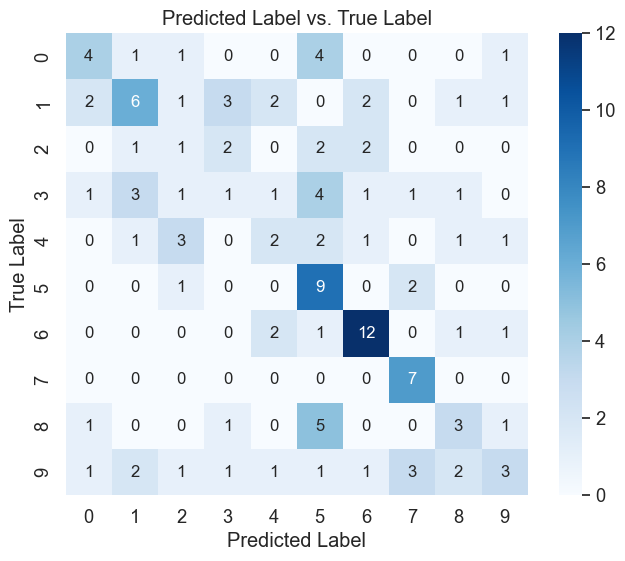

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test_mariposas, y_pred_test)

# Crea un mapa de calor de la matriz de confusión con una barra de color
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, annot_kws={'size': 12})

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Predicted Label vs. True Label')
plt.show()
